<a href="https://colab.research.google.com/github/RbsFaneva/Quant-Trading/blob/main/bot_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Data and analysis libraries
import polars as pl                         # Data frames for financial data
import numpy as np                          # Numerical computing library
from datetime import datetime, timedelta    # Date and time operation
import random

# Machine learning libraries
import torch                                # PyTorch framwork
import torch.nn as nn                       # Neural network modules
import torch.optim as optim                 # Optimization algorithms
import research

# Visualization
import altair as alt                        # Interactive visualization library

# Data sources
import binance                              # Binance market

In [9]:
research.set_seed(42)

In [ ]:
pl.Config.set_tbl_width_chars(200)
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(-1)  # Show all columns

In [12]:
# Trading pair symbol
sym = 'BTCUSDT'
#Historical window in days (e.g., 6 months)
hist_data_window = 7 * 4 * 6
# time horizon of time series (time interval)
time_interval = '1h'
# Max number of auto-regressive lags
max_lags = 4
# Forecast horizon in steps
forecast_horizon = 1
# Sharpe annualized rate (so it's independent of time frequency)
annualized_rate = research.sharpe_annualization_factor(time_interval, 365, 24)

In [13]:
binance.download_trades(sym, hist_data_window)

In [15]:
ts = research.load_ohlc_timeseries(sym, time_interval)
ts

Loading BTCUSDT: 100%|██████████| 168/168 [01:32<00:00,  1.82file/s]


datetime,open,high,low,close
datetime[μs],f64,f64,f64,f64
2025-08-17 00:00:00,117329.8,117380.5,117191.5,117204.2
2025-08-17 01:00:00,117204.1,117449.4,117121.6,117383.7
2025-08-17 02:00:00,117383.8,117594.0,117330.1,117559.1
2025-08-17 03:00:00,117559.0,117722.5,117459.0,117627.4
2025-08-17 04:00:00,117627.3,118146.4,117627.3,118023.5
…,…,…,…,…
2026-01-31 19:00:00,77996.8,78527.1,77144.1,77707.9
2026-01-31 20:00:00,77707.9,78106.0,77037.8,77956.7
2026-01-31 21:00:00,77956.6,78330.8,77323.1,78252.4


In [16]:
research.load_timeseries(sym, time_interval, pl.col('price').quantile(0.5).alias('price_median'))

Loading BTCUSDT: 100%|██████████| 168/168 [01:44<00:00,  1.60file/s]


datetime,price_median
datetime[μs],f64
2025-08-17 00:00:00,117274.9
2025-08-17 01:00:00,117281.6
2025-08-17 02:00:00,117458.2
2025-08-17 03:00:00,117578.5
2025-08-17 04:00:00,117926.8
…,…
2026-01-31 19:00:00,77888.2
2026-01-31 20:00:00,77516.0
2026-01-31 21:00:00,77882.7


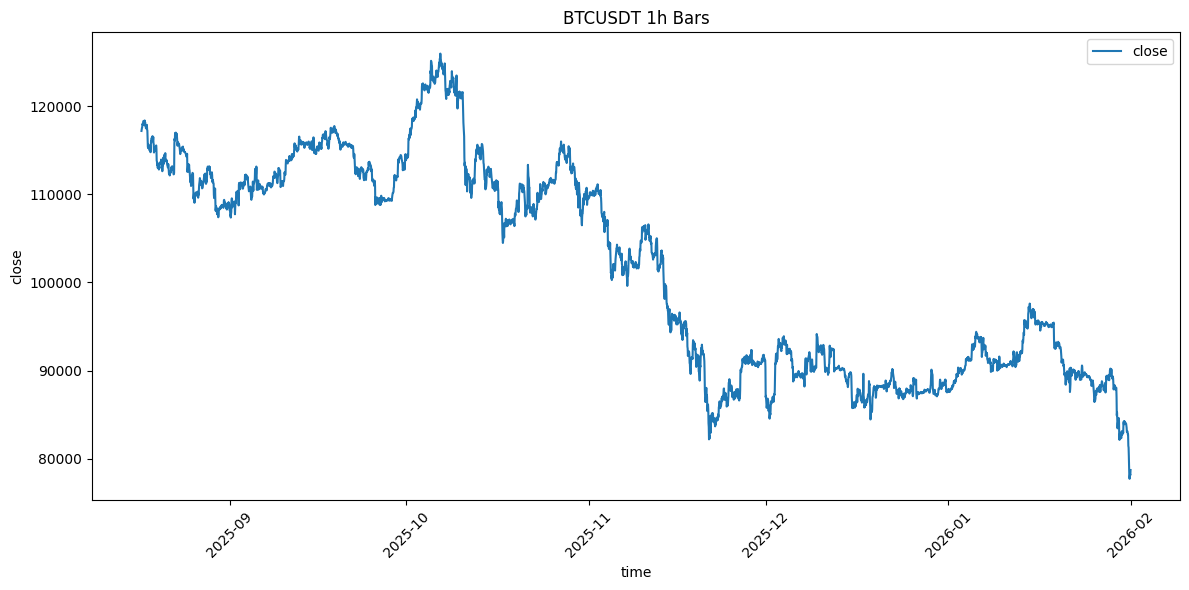

In [17]:
research.plot_static_timeseries(ts, sym, 'close', time_interval)